In [1]:
# -- coding: utf-8 --
# This code is part of Qiskit.
#
# (C) Copyright IBM 2019.
#
# This code is licensed under the Apache License, Version 2.0. You may
# obtain a copy of this license in the LICENSE.txt file in the root directory
# of this source tree or at http://www.apache.org/licenses/LICENSE-2.0.
#
# Any modifications or derivative works of this code must retain this
# copyright notice, and modified files need to carry a notice indicating
# that they have been altered from the originals.
#
# Code adapted from QizGloria team, Qiskit Camp Europe 2019, updated by 
# Team Ube Pancake, Qiskit Summer Jam 2020
#
# WORKS for Quantum Circuit with variable number of qubits! Now supports running on GPU (CUDA)

In [1]:
import torch
from torch.autograd import Function
import torch.optim as optim
import torch.nn as nn

# if torch.cuda.is_available():
#     device = torch.device("cuda:0")
#     print("Running on the GPU")
# else:
#     device = torch.device("cpu")
#     print("Running on the CPU")
    
# torch.device("cpu")

In [2]:
from qiskit import execute
from qiskit.circuit import Parameter,ControlledGate
from qiskit import Aer
import qiskit
import numpy as np

In [3]:
from tqdm import tqdm

In [4]:
from matplotlib import pyplot as plt
%matplotlib inline

In [5]:
np.random.seed = 42

NUM_QUBITS = 3
NUM_SHOTS = 3000
SHIFT = np.pi/4
LEARNING_RATE = 0.01
MOMENTUM = 0.5

SIMULATOR = Aer.get_backend('qasm_simulator')

In [6]:
# create list of all possible outputs of quantum circuit (2**NUM_QUBITS possible)
import itertools
def create_QC_OUTPUTS():
    measurements = list(itertools.product([0, 1], repeat=NUM_QUBITS))
    return [''.join([str(bit) for bit in measurement]) for measurement in measurements]

QC_OUTPUTS = create_QC_OUTPUTS()
print(QC_OUTPUTS)

['000', '001', '010', '011', '100', '101', '110', '111']


Define function to translate Q-Circuit parameters from pytorch back to QISKIT

## 3. Contruct QuantumCircuit QFT Class

In [7]:
class QiskitCircuit():
    
    def __init__(self, n_qubits, backend, shots):
        # --- Circuit definition ---
        self.circuit = qiskit.QuantumCircuit(n_qubits)
        self.n_qubits = n_qubits
        self.thetas ={k : Parameter('Theta'+str(k))for k in range(self.n_qubits)}
        
        all_qubits = [i for i in range(n_qubits)]
        self.circuit.h(all_qubits)
        self.circuit.barrier()
        for k in range(n_qubits):
            self.circuit.ry(self.thetas[k], k)
        
#         # Apply controlled-unitary
# #         uc=ry(self.theta4, 4).to_gate().control(4)
# #         self.circuit.append(uc, [0,1,2,3,4])
#         self.circuit.ry(self.theta4, 4).to_gate().control(4)

        self.circuit.measure_all()
        # ---------------------------
        
        self.backend = backend
        self.shots = shots
        
#             check = perc
#             for i in range(nr_qubits):
#                 check *= (float(key[i])-1/2)*2
#             expects += check   
        
    def N_qubit_expectation_Z(self,counts, shots, nr_qubits):
        expects = np.zeros(len(QC_OUTPUTS))
        for k in range(len(QC_OUTPUTS)):
            key = QC_OUTPUTS[k]
            perc = counts.get(key, 0) /shots
            expects[k] = perc
        return expects
    
    def run(self, i):
        params = i
#         print('params = {}'.format(len(params)))
        backend = Aer.get_backend('qasm_simulator')
    
        bound_circuit = self.circuit.bind_parameters({self.thetas[k] : params[k].item() for k in range(NUM_QUBITS)}) 
        job_sim = execute(bound_circuit, self.backend, shots=self.shots)
#         
        result_sim = job_sim.result()
        counts = result_sim.get_counts()
        return self.N_qubit_expectation_Z(counts,self.shots,NUM_QUBITS)

Expected value for rotation [pi/4]: [0.00233333 0.01933333 0.01966667 0.11666667 0.021      0.10733333
 0.10766667 0.606     ]


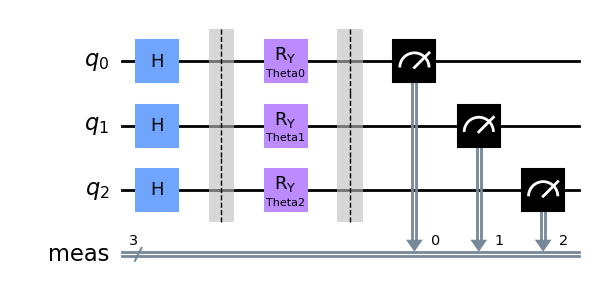

In [8]:
circuit = QiskitCircuit(NUM_QUBITS, SIMULATOR, NUM_SHOTS)
print('Expected value for rotation [pi/4]: {}'.format(circuit.run(torch.Tensor([np.pi/4]*NUM_QUBITS))))
circuit.circuit.draw(output='mpl')#, filename='Figures/{}-qubit circuit ryN.jpg'.format(NUM_QUBITS)

### TorchCircuit()

A pytorch layer always has two functions. One for the forward pass and one for the backward pass. The forward pass simply takes the Quantum Circuits variational parameters from the previous pytorch layer and runs the circuit on the defined hardware (defined in `QiskitCircuit.run()`) and returns the measurements from the quantum hardware.
These measurements will be the inputs of the next pytorch layer.

The backward pass returns the gradients of the quantum circuit. In this case here it is finite difference.

the `forward_tensor` is saved from the forward pass. So we just have to do one evaluation of the Q-Circuit in the backpass for the finite difference.

The `gradient` variable here is as well hard coded to 3 parameters. This should be updated in the future and made more general.

The loop `for k in range(len(input_numbers)):` goes through all the parameters (in this case 3), and shifts them by a small $\epsilon$. Then it runs the circuit and takes the diefferences of the ouput for the parameters $\Theta$ and $\Theta + \epsilon$. This is the finite difference. 

In [9]:
class TorchCircuit(Function):    

    @staticmethod
    def forward(ctx, i):
        if not hasattr(ctx, 'QiskitCirc'):
            ctx.QiskitCirc = QiskitCircuit(NUM_QUBITS, SIMULATOR, shots=NUM_SHOTS)
            
        exp_value = ctx.QiskitCirc.run(i)
        
        result = torch.tensor([exp_value])
        
        
        ctx.save_for_backward(result, i)
        
        return result
    
    @staticmethod
    def backward(ctx, grad_output):
        
        forward_tensor, i = ctx.saved_tensors
#         print('forward_tensor = {}'.format(forward_tensor))
        input_numbers = i
#         print('input_numbers = {}'.format(input_numbers))
        gradients = torch.Tensor()
        
        for k in range(NUM_QUBITS):
            shift_right = input_numbers.detach().clone()
            shift_right[k] = shift_right[k] + SHIFT
            shift_left = input_numbers.detach().clone()
            shift_left[k] = shift_left[k] - SHIFT
            
#             print('shift_right = {}, shift_left = {}'.format(shift_right, shift_left))
            
            expectation_right = ctx.QiskitCirc.run(shift_right)
            expectation_left  = ctx.QiskitCirc.run(shift_left)
#             print('expectation_right = {}, \nexpectation_left = {}'.format(expectation_right, expectation_left))
            
            gradient = torch.tensor([expectation_right]) - torch.tensor([expectation_left])
            # rescale gradient
#             gradient = gradient / torch.norm(gradient)
#             print('gradient for k={}: {}'.format(k, gradient))
            gradients = torch.cat((gradients, gradient.float()))
            
        result = torch.Tensor(gradients)
#         print('gradients = {}'.format(result))
#         print('grad_output = {}'.format(grad_output))

        return (result.float() * grad_output.float()).T

In [10]:
x = torch.tensor([np.pi/4]*NUM_QUBITS, requires_grad=True)

qc = TorchCircuit.apply
y1 = qc(x)
print('y1 after quantum layer: {}'.format(y1))
y1 = nn.Linear(2**NUM_QUBITS,1)(y1.float())
y1.backward()
print('x.grad = {}'.format(x.grad))

/tmp/ipykernel_18037/1768170039.py:10: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1682343964576/work/torch/csrc/utils/tensor_new.cpp:245.)
  result = torch.tensor([exp_value])


y1 after quantum layer: tensor([[0.0023, 0.0193, 0.0187, 0.1150, 0.0197, 0.1030, 0.1070, 0.6150]],
       dtype=torch.float64, grad_fn=<TorchCircuitBackward>)
x.grad = tensor([-0.0055,  0.0362,  0.1194])


### MNIST in pytorch

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

### Load MNIST (0-1) Dataset

**Training Data**

In [21]:
import numpy as np
import torchvision
from torchvision import datasets, transforms

# Concentrating on the first 100 samples
n_samples = 150

X_train = datasets.FashionMNIST(root='./data', train=True, download=True,
                         transform=transforms.Compose([transforms.ToTensor()]))

idx = np.append(np.where(X_train.targets == 0)[0][:n_samples], 
                np.where(X_train.targets == 1)[0][:n_samples])
idx = np.append(idx, 
                np.where(X_train.targets == 2)[0][:n_samples])
idx = np.append(idx, 
                np.where(X_train.targets == 3)[0][:n_samples])
idx = np.append(idx, 
                np.where(X_train.targets == 4)[0][:n_samples])
idx = np.append(idx, 
                np.where(X_train.targets == 5)[0][:n_samples])
idx = np.append(idx, 
                np.where(X_train.targets == 6)[0][:n_samples])
idx = np.append(idx, 
                np.where(X_train.targets == 7)[0][:n_samples])

X_train.data = X_train.data[idx]
X_train.targets = X_train.targets[idx]


train_loader = torch.utils.data.DataLoader(X_train, batch_size=1, shuffle=True, pin_memory=True)

**Testing Data**

In [22]:
n_samples = 150

X_test = datasets.FashionMNIST(root='./data', train=False, download=True,
                        transform=transforms.Compose([transforms.ToTensor()]))

idx = np.append(np.where(X_test.targets == 0)[0][:n_samples], 
                np.where(X_test.targets == 1)[0][:n_samples])
idx = np.append(idx, 
                np.where(X_test.targets == 2)[0][:n_samples])
idx = np.append(idx, 
                np.where(X_test.targets == 3)[0][:n_samples])
idx = np.append(idx, 
                np.where(X_test.targets == 4)[0][:n_samples])
idx = np.append(idx, 
                np.where(X_test.targets == 5)[0][:n_samples])
idx = np.append(idx, 
                np.where(X_test.targets == 6)[0][:n_samples])
idx = np.append(idx, 
                np.where(X_test.targets == 7)[0][:n_samples])

X_test.data = X_test.data[idx]
X_test.targets = X_test.targets[idx]

test_loader = torch.utils.data.DataLoader(X_test, batch_size=1, shuffle=True)

### Define Neural Network with Q-node

This NN is  2 layers of ConvNN and a fully connected layer, with a Q-Node as a classifier.

In [23]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, NUM_QUBITS)
        self.qc = TorchCircuit.apply
        self.qcsim = nn.Linear(NUM_QUBITS, 1)
        self.fc3 = nn.Linear(1, 4)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        x = np.pi*torch.tanh(x)
        
#         print('params to QC: {}'.format(x))

        MODE = 'QC' # 'QC' or 'QC_sim'
    
        if MODE == 'QC': 
            x = qc(x[0]) # QUANTUM LAYER
        
        else:
            x = self.qcsim(x)
            
#         print('output of QC = {}'.format(x))
        
#         # softmax rather than sigmoid
#         x = self.fc3(x.float())
#         print('output of Linear(1, 2): {}'.format(x))
#         x = F.softmax(x, 1)

        # Convert frequency distribution into probability distribution
        x = F.softmax(x, dim=1)
#         print(x)
        return x
    
    
    def predict(self, x):
        # apply softmax
        pred = self.forward(x)
#         print(pred)
        ans = torch.argmax(pred[0]).item()
        return torch.tensor(ans)
    
network = Net()#.to(device)
optimizer = optim.Adam(network.parameters(), lr=0.001)

# optimizer = optim.Adam(network.parameters(), lr=learning_rate)

In [24]:
total_params = sum(p.numel() for p in network.parameters() if p.requires_grad)
print("Number of trainable parameters:", total_params)

Number of trainable parameters: 21495


In [25]:
class LeNet5(nn.Module):
    def __init__(self, num_classes=8):
        super(LeNet5, self).__init__()
        
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2)
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(in_features=16*4*4, out_features=120),
            nn.Tanh(),
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=num_classes)
        )
        
    def forward(self, x):
        x = self.feature_extractor(x)
        x = x.view(-1, 16*4*4)  # Flatten the tensor
        logits = self.classifier(x)
        return logits


In [26]:
teacher_model = LeNet5(num_classes=8)
teacher_model.load_state_dict(torch.load("lenet fashionmnist 0-7.pth"))
teacher_model.eval()

LeNet5(
  (feature_extractor): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=120, bias=True)
    (1): Tanh()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): Tanh()
    (4): Linear(in_features=84, out_features=8, bias=True)
  )
)

In [27]:
def distillation_loss(y, teacher_scores, T=3.0, alpha=0.9):
    # Get the soft targets from the teacher model
    teacher_probs = F.softmax(teacher_scores / T, dim=1)
    # Calculate KL divergence
    kd_loss = nn.KLDivLoss()(F.log_softmax(y/T, dim=1), teacher_probs) * (T * T * 8 * alpha)
    return kd_loss


In [28]:
epochs = 10
loss_list = []
val_loss_list = []
loss_func = nn.CrossEntropyLoss()
best = 0

for epoch in range(epochs):
    network.train()
    
    total_loss = []
    for batch_idx, (data, target) in enumerate(tqdm(train_loader)):
#         print(batch_idx)
        optimizer.zero_grad()        
        # Forward pass
        output = network(data)
        
        # Forward pass in teacher
        with torch.no_grad():
            output_teacher = teacher_model(data)
            
        # Calculating loss
        loss = loss_func(output, target)
        
        # Calculate the distillation loss using only first 6 outputs of student
        kd_loss = distillation_loss(output[:, :8], output_teacher)
        
        loss = loss + kd_loss*0
        
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        total_loss.append(loss.item())
        
    loss_list.append(sum(total_loss)/len(total_loss))
    print('Training [{:.0f}%]\tLoss: {:.4f}'.format(
        100. * (epoch + 1) / epochs, loss_list[-1]))
    
    network.eval()
    
    accuracy = 0
    number = 0
    
    with torch.no_grad():
        total_val_loss = []
        for batch_idx, (data, target) in enumerate(test_loader):
            number +=1
            output = network(data)
            
            # Calculating loss
            loss = loss_func(output, target)
            
            output = network.predict(data).item()
            
            total_val_loss.append(loss.item())
        
            accuracy += (output == target[0].item())*1
            
        accuracy = 100*accuracy/number
        
        if accuracy > best:
            best = accuracy
            torch.save(network.state_dict(), 'distil t=lenet s=fashion0-7 3qubits.pth')
            
        val_loss_list.append(sum(total_val_loss)/len(total_val_loss))
        print("Val loss: {} and accuracy = {}%".format(val_loss_list[-1],accuracy))

100%|███████████████████████████████████████| 1200/1200 [01:27<00:00, 13.71it/s]


Training [10%]	Loss: 2.0613
Val loss: 2.025418608459208 and accuracy = 54.583333333333336%


100%|███████████████████████████████████████| 1200/1200 [01:25<00:00, 14.00it/s]


Training [20%]	Loss: 2.0398
Val loss: 2.0134966145539104 and accuracy = 57.25%


100%|███████████████████████████████████████| 1200/1200 [01:25<00:00, 14.07it/s]


Training [30%]	Loss: 2.0302
Val loss: 2.000305681384218 and accuracy = 66.5%


100%|███████████████████████████████████████| 1200/1200 [01:25<00:00, 14.12it/s]


Training [40%]	Loss: 2.0222
Val loss: 2.001868695428105 and accuracy = 66.5%


100%|███████████████████████████████████████| 1200/1200 [01:25<00:00, 14.10it/s]


Training [50%]	Loss: 2.0201
Val loss: 1.9987769083484315 and accuracy = 67.16666666666667%


100%|███████████████████████████████████████| 1200/1200 [01:25<00:00, 14.08it/s]


Training [60%]	Loss: 2.0164
Val loss: 1.9946483886725788 and accuracy = 68.16666666666667%


100%|███████████████████████████████████████| 1200/1200 [01:25<00:00, 14.10it/s]


Training [70%]	Loss: 2.0160
Val loss: 1.996380318126053 and accuracy = 68.0%


100%|███████████████████████████████████████| 1200/1200 [01:25<00:00, 14.10it/s]


Training [80%]	Loss: 2.0128
Val loss: 1.9959931920313423 and accuracy = 67.83333333333333%


100%|███████████████████████████████████████| 1200/1200 [01:25<00:00, 14.11it/s]


Training [90%]	Loss: 2.0148
Val loss: 1.9984114909627022 and accuracy = 68.66666666666667%


100%|███████████████████████████████████████| 1200/1200 [01:25<00:00, 14.08it/s]


Training [100%]	Loss: 2.0110
Val loss: 1.995217828200324 and accuracy = 68.41666666666667%


In [29]:
print('Best accuracy = {}'.format(best))

Best accuracy = 68.66666666666667


In [30]:
def normalize_list(numbers):
    min_value = min(numbers)
    max_value = max(numbers)
    return [(x - min_value) / (max_value - min_value) for x in numbers]

loss_list = normalize_list(loss_list)
val_loss_list = normalize_list(val_loss_list)

/tmp/ipykernel_18037/3357998750.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


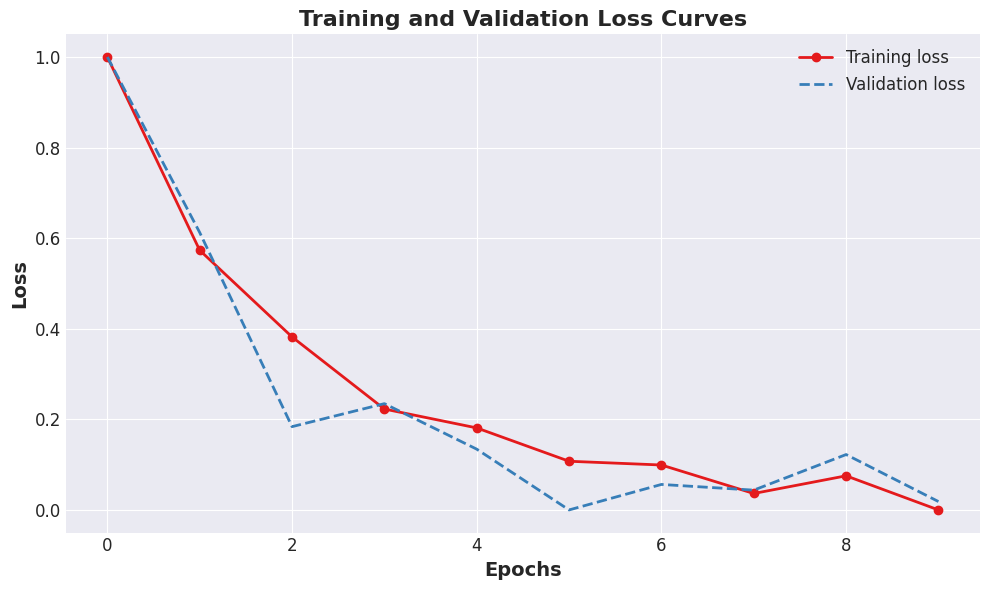

In [31]:
import matplotlib.pyplot as plt

# Use a professional style
plt.style.use('seaborn-darkgrid')

# Create a color palette
color_palette = plt.get_cmap('Set1')

# Set up the figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Plotting both the curves simultaneously with enhanced aesthetics
ax.plot(loss_list, color=color_palette(0), marker='o', linestyle='-', linewidth=2, label='Training loss')
ax.plot(val_loss_list, color=color_palette(1), marker='', linestyle='--', linewidth=2, label='Validation loss')

# Naming the x-axis, y-axis and the whole graph with enhanced font properties
ax.set_xlabel("Epochs", fontsize=14, fontweight='bold')
ax.set_ylabel("Loss", fontsize=14, fontweight='bold')
ax.set_title("Training and Validation Loss Curves", fontsize=16, fontweight='bold')

# Displaying the legend with larger font size
ax.legend(fontsize=12)

# Enhance tick visibility and size
ax.tick_params(axis='both', which='major', labelsize=12)

# Adjust the plot for better layout
plt.tight_layout()

# Saving the graph in high quality
plt.savefig("distil t = lenet s = fashionmnist 0-7 3qubits loss curve.png", dpi=300)

# Displaying the graph
plt.show()
